In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost
import shap

from sklearn import datasets, ensemble
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [4]:
# Initialize SHAP visualizations
shap.initjs()

## Prepare data

In [5]:
# Load and prepare the data
file_path = "../data/df_restaurants_model.csv"
df_restaurants_model = pd.read_csv(file_path)

In [6]:
# Convert boolean columns to integers
df_restaurants_model = df_restaurants_model.astype({col: 'int' for col in df_restaurants_model.select_dtypes(include=['bool']).columns})

In [7]:
# Feature engineering: create interaction term
df_restaurants_model['delivery_drive_thru'] = df_restaurants_model['delivery'] * df_restaurants_model['drive_thru']

In [8]:
# Define the target and feature set
X = df_restaurants_model.drop(columns=['stars'])

In [9]:
# Safely drop columns that may not exist
columns_to_drop = ['appointment_only', 'coat_check', 'drive_thru', 'hours_weekend']
X_reduced = X.drop(columns=[col for col in columns_to_drop if col in X.columns])

y = df_restaurants_model['stars']

In [10]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42)

# Create a pipeline for preprocessing
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Preprocess the data
X_train_processed = pipeline.fit_transform(X_train)
X_test_processed = pipeline.transform(X_test)

# Convert the scaled data back into DataFrames (ensure column names match the processed data)
X_train_processed_df = pd.DataFrame(X_train_processed, columns=X_train.columns, index=X_train.index)
X_test_processed_df = pd.DataFrame(X_test_processed, columns=X_test.columns, index=X_test.index)

## Fit a model

In [11]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42)

In [12]:
# Create a pipeline for preprocessing
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Preprocess the data
X_train_processed = pipeline.fit_transform(X_train)
X_test_processed = pipeline.transform(X_test)

# Convert the scaled data back into DataFrames
X_train_processed_df = pd.DataFrame(X_train_processed, columns=X_train.columns)
X_test_processed_df = pd.DataFrame(X_test_processed, columns=X_test.columns)

In [13]:
# Fit the XGBoost model
model_tree = xgboost.XGBRegressor(n_estimators=100, max_depth=2, random_state=42)
model_tree.fit(X_train_processed_df, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=2, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, ...)

## Look at predictions

In [14]:
# Predict on the test data
y_test_pred = model_tree.predict(X_test_processed_df)

In [15]:
# Average star rating in the training set
print(f"The average star rating in the train set is {y_train.mean():.3f}")

The average star rating in the train set is 3.512


In [16]:
# Calculate MSE on the test set
mse = mean_squared_error(y_test, y_test_pred)
print(f"The Mean Squared Error on the test set is {mse:.3f}")

The Mean Squared Error on the test set is 0.426


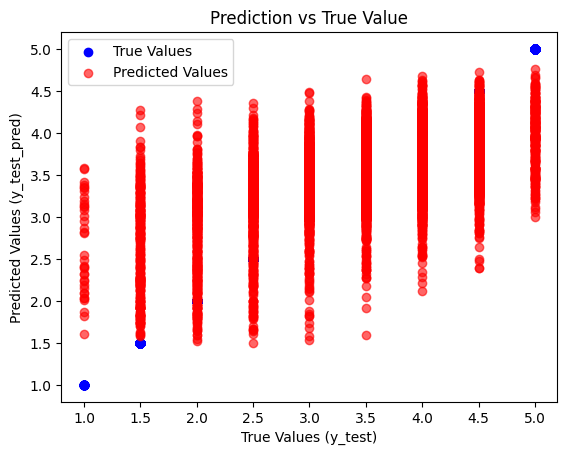

In [17]:
# Plot Prediction vs True Value
plt.scatter(y_test, y_test, label="True Values", color='blue')
plt.scatter(y_test, y_test_pred, label="Predicted Values", color='red', alpha=0.6)
plt.title("Prediction vs True Value")
plt.xlabel("True Values (y_test)")
plt.ylabel("Predicted Values (y_test_pred)")
plt.legend()
plt.show()

## Local explainability

In [23]:
# SHAP Analysis: Select one instance to explain
row_to_show = 24
feature_values = X_test_processed_df.iloc[[row_to_show]]
prediction = model_tree.predict(feature_values)
print(f"Prediction for instance {row_to_show}: {prediction[0]:.3f}")

Prediction for instance 24: 3.956


## Calculate the SHAP values (locally)

In [24]:
# Step 1: Create a SHAP Explainer
explainer = shap.Explainer(model_tree, X_train_processed_df)

In [25]:
# Step 2: Calculate SHAP values for the selected instance
shap_values_one = explainer(feature_values)

In [26]:
# Step 3: Display SHAP values and SHAP plots
print(f"Base value (average model output): {shap_values_one.base_values[0]:.3f}")
print(f"Sum of SHAP values (contributions): {shap_values_one.values.sum():.3f}")
print(f"Prediction for this instance: {prediction[0]:.3f}")

Base value (average model output): 3.538
Sum of SHAP values (contributions): 0.418
Prediction for this instance: 3.956


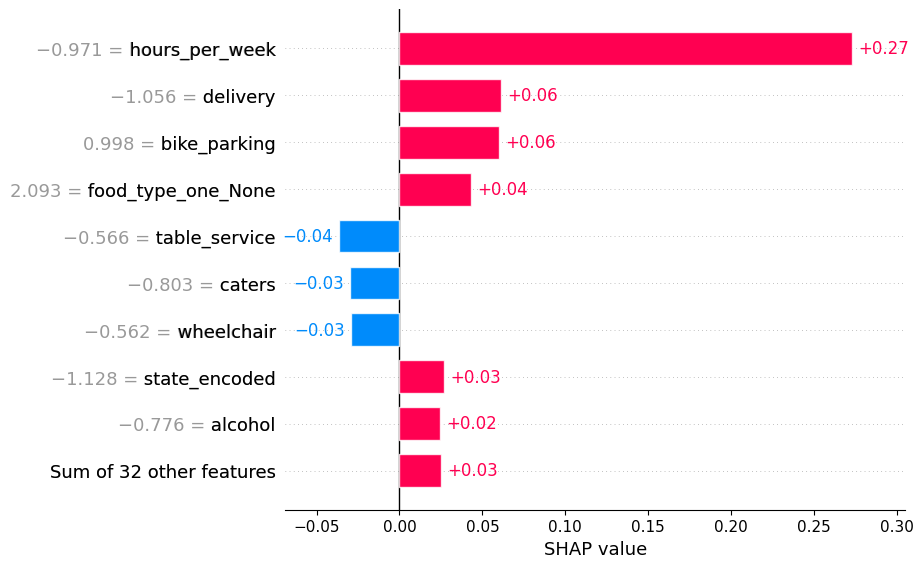

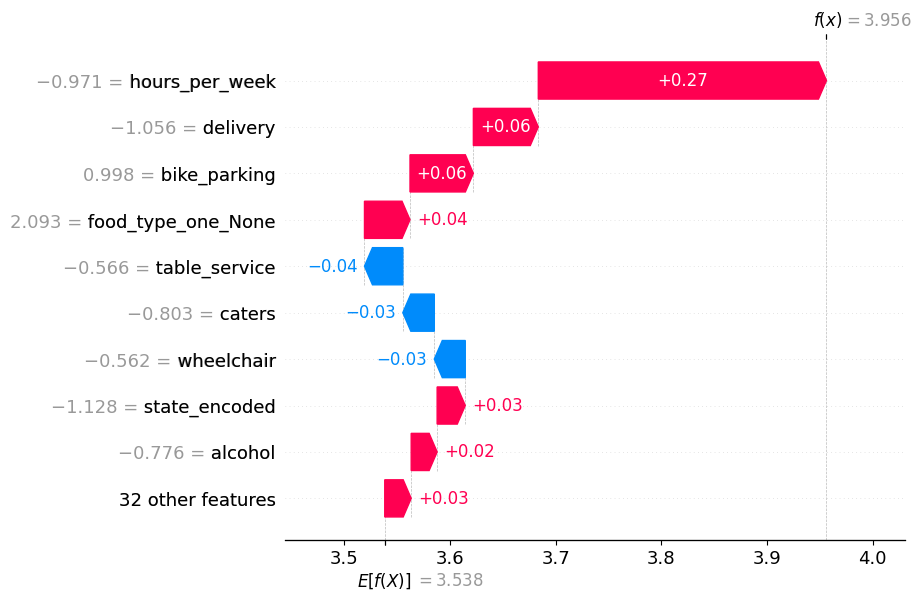

In [27]:
# Visualize SHAP values with a bar and waterfall plot
shap.plots.bar(shap_values_one[0])
shap.plots.waterfall(shap_values_one[0])

## Global explainability

In [28]:
# Calculate SHAP values for our whole test population
shap_values = explainer(X_test_processed_df)

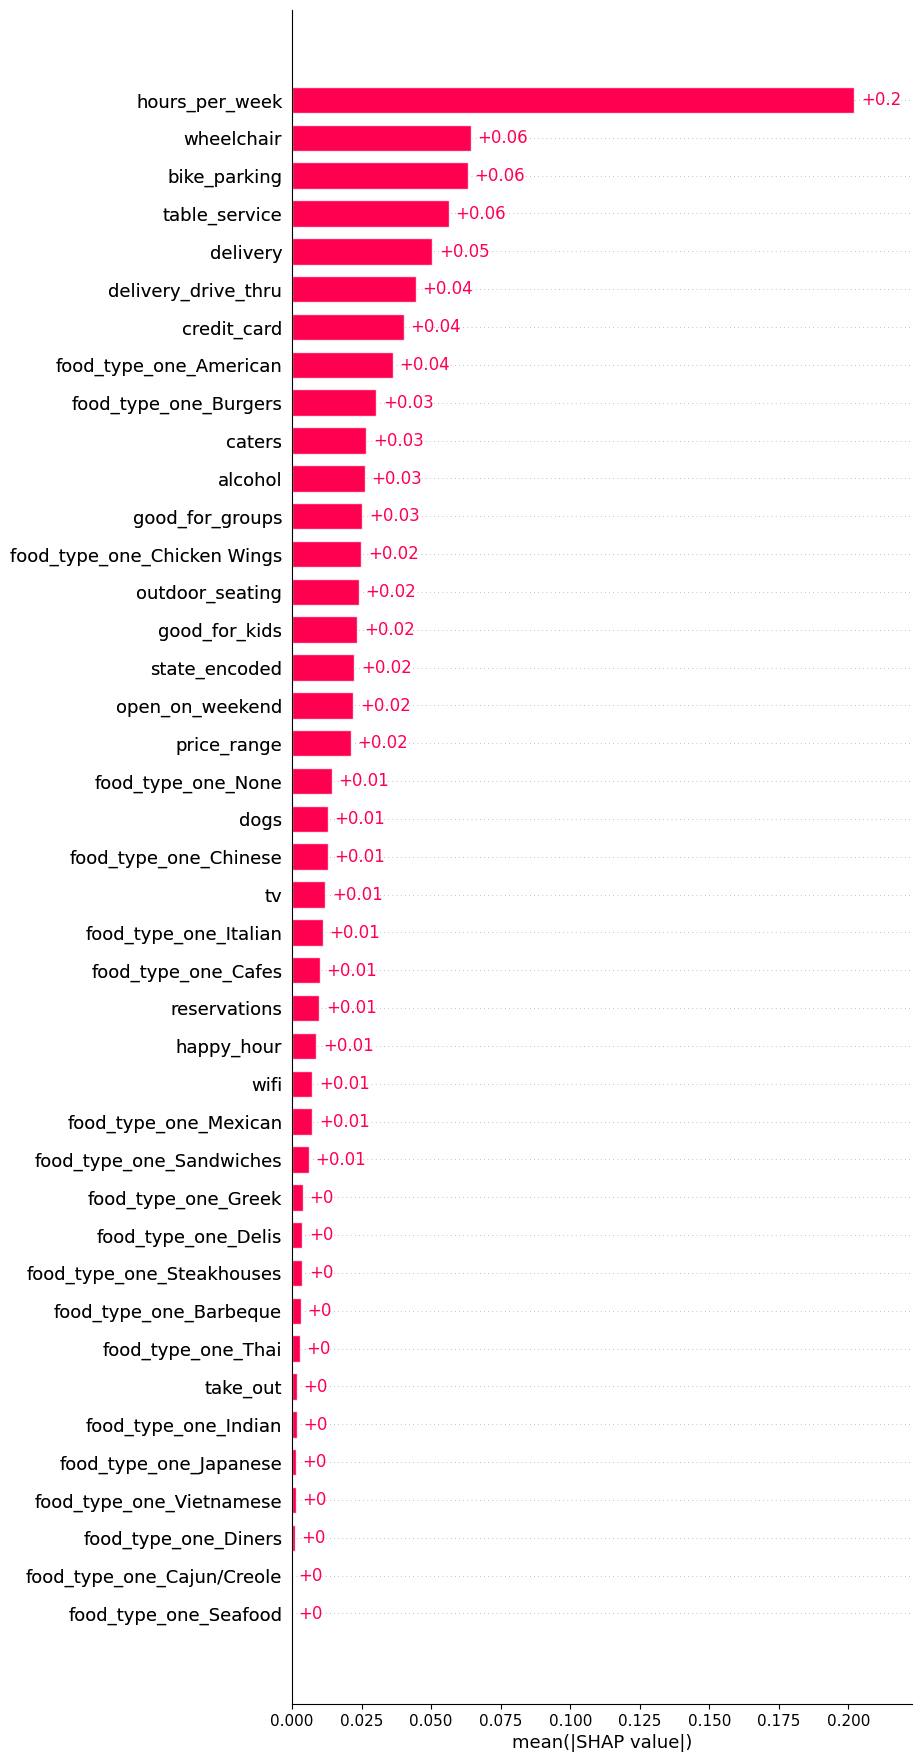

In [29]:
# Rank the features by their average absolute SHAP values
shap.plots.bar(shap_values, max_display=50)

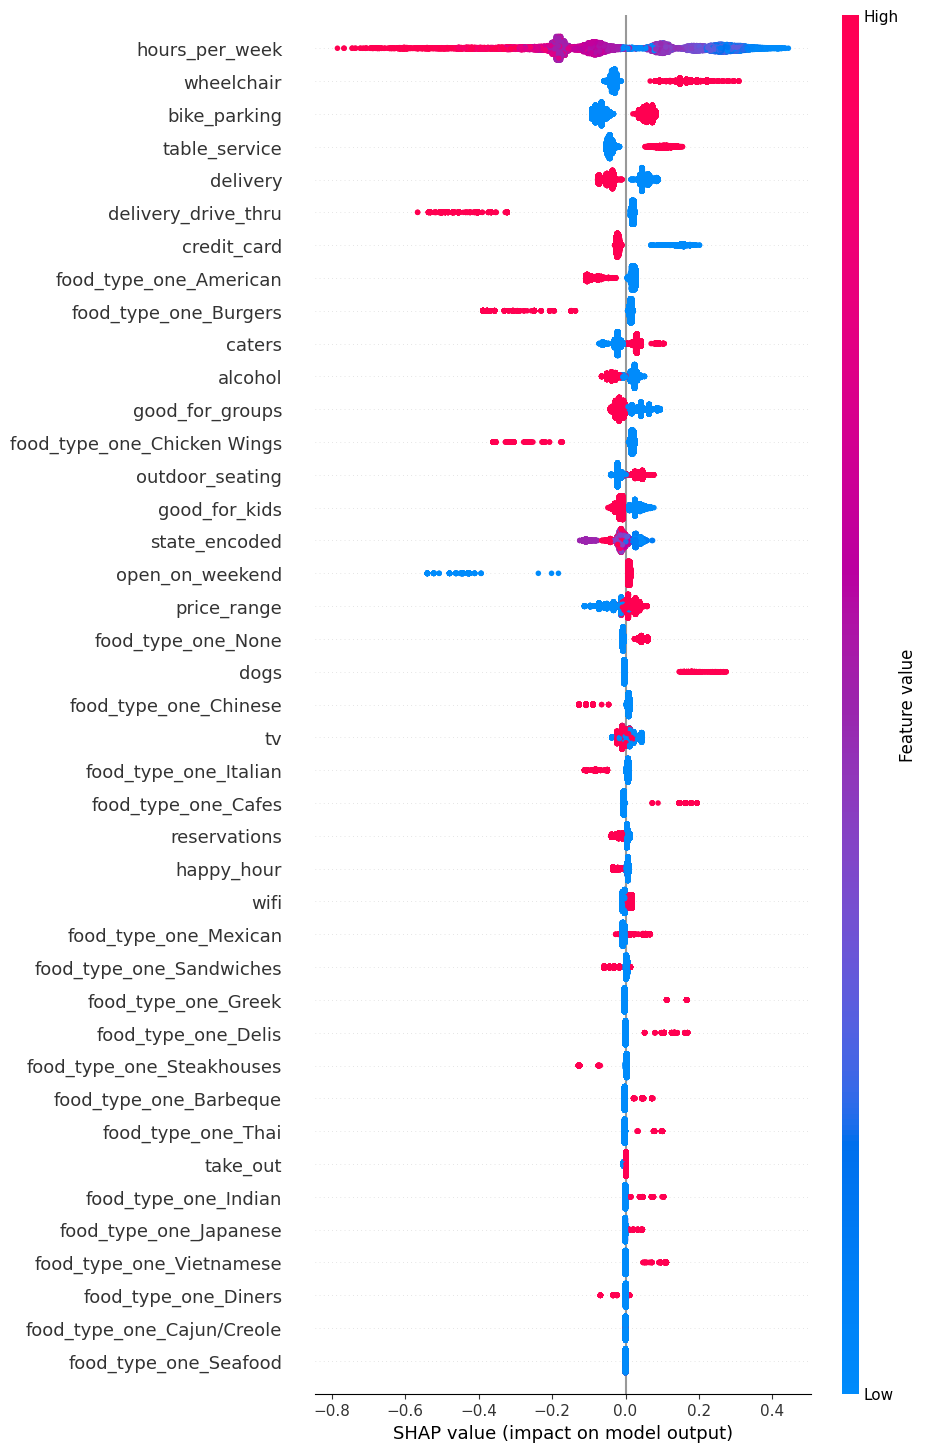

In [30]:
# Showcase feature importance and feature effect for every feature
shap.plots.beeswarm(shap_values, max_display=50)

In [31]:
# Convert SHAP values to a DataFrame for easier manipulation
shap_values_df = pd.DataFrame(shap_values.values, columns=X_test_processed_df.columns)

# Calculate mean absolute SHAP values for each feature
mean_abs_shap_values = np.abs(shap_values_df).mean()

# Create a DataFrame with feature names and their mean absolute SHAP values
shap_feature_importance = pd.DataFrame({
    'Feature': mean_abs_shap_values.index,
    'Mean Abs SHAP Value': mean_abs_shap_values.values
})

# Sort features by mean absolute SHAP value (importance) in descending order
shap_feature_importance = shap_feature_importance.sort_values(by='Mean Abs SHAP Value', ascending=False)

# Get the top 5 or top 10 features (change n to get the number of features you want)
top_n_features = 10
top_features = shap_feature_importance.head(top_n_features)

# Display the top features with their SHAP values
print(top_features)

                   Feature  Mean Abs SHAP Value
17          hours_per_week             0.202128
15              wheelchair             0.064379
2             bike_parking             0.063221
13           table_service             0.056370
0                 delivery             0.050398
40     delivery_drive_thru             0.044553
3              credit_card             0.040102
19  food_type_one_American             0.036199
21   food_type_one_Burgers             0.030286
4                   caters             0.026743
